TODO:

Per ogni coppia, fai un loop cosi che vengano printate tutte (se ci sono 2 SN e un EN, abbiamo 3 plot)

Per ogni rna, colleziona tutte le sue interazioni, cosi che possiamo plottare le regioni di interazione.

Per ogni rna, colleziona le sue caratteristiche (CDS,UTR, Simple repeat) cosi che possiamo plottarle

Mostra che all aumentare della distanza dal sito di interazione la qualita di EN, HN migliora, e se aumenta la confidenza del modello

Aggiungi plots INTARNA a questo script. Potremmo prendere le 10 coppie top positive predette da intarna e le 10 top positive predette da noi (che siano pero anche grandi, tipo > 4_000, e normalizziamo lo score di intarna.

In [1]:
import pandas as pd
import os
import time
import numpy as np
import seaborn as sns
import pickle
import torch
from pathlib import Path
import argparse
import math
import matplotlib.patches as patches
from scipy import stats
from Bio import SeqIO
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import sys
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, auc

sys.path.insert(0, '..')

from util.xai import gradcam, interpolate_expl_matrix, plot_matrix
from config import *
from models.nt_classifier import build as build_model 
from util.plot_utils import balance_df, map_signal_to_sigmoid_range, obtain_plot, plot_logs, plot_roc_curves, collect_results_based_on_confidence_level_how_many1, acc_for_each_class
from util.plot_utils import collect_results_based_on_confidence_level_based_on_percentile as collect_results_based_on_confidence_level
from train_binary_cl import (
    get_args_parser,
)

from dataset.data import (
    FindSplits,
    RNADatasetInference
)

<class 'transformers.tokenization_dna.DNATokenizer'>


In [2]:
external_dataset_files_dir = os.path.join(ROOT_DIR, "dataset", "external_dataset")
windows_dir = os.path.join(external_dataset_files_dir, "windows")

In [3]:
how = 'splash'

assert how in ['splash', 'ricseq']

In [4]:
sys.argv = ['']
parser = argparse.ArgumentParser('Training', parents=[get_args_parser()])
args = parser.parse_args()

# OR LIKE THIS?
checkpoint_dir = os.path.join(ROOT_DIR, 'checkpoints', 'all_modelarch2_easypretrain11_paristfinetuningSPLASHval0061')
with open(os.path.join(checkpoint_dir, 'args.pkl'), 'rb') as fp:
    args = pickle.load(fp)

In [5]:
if how == 'splash':
    df_genes = pd.read_csv(os.path.join(processed_files_dir, f'df_genes_splash.csv'))
else:
    df_genes = pd.read_csv(os.path.join(processed_files_dir, f'df_gene.csv'))
df = pd.read_csv(os.path.join(processed_files_dir, f'{how}.csv'))
df_nt = pd.read_csv(os.path.join(metadata_dir, f'df_nt_{how}.csv'))

test500 = pd.read_csv(os.path.join(metadata_dir, f'{how}500.csv'))
if how == 'ricseq':
    test500 = df_nt[['couples', 'interacting', 'policy', 'where', 'where_x1', 'where_y1', 'n_reads']].merge(test500, on = 'couples')
else:
    test500 = df_nt[['couples', 'interacting', 'policy', 'where', 'where_x1', 'where_y1']].merge(test500, on = 'couples')



# splash = pd.read_csv(os.path.join(processed_files_dir, f'splash.csv'))
# paris = pd.read_csv(os.path.join(processed_files_dir, f'paris.csv'))

In [6]:
DEVICE = 'cpu'

args_path = os.path.join(checkpoint_dir, 'args.pkl')

# Load the args namespace from the file
with open(args_path, 'rb') as f:
    args_dict = pickle.load(f)

# Convert the dictionary to an argparse.Namespace object
args = argparse.Namespace(**args_dict)
args.resume = os.path.join(checkpoint_dir, 'best_model.pth') # best_model

device = torch.device(DEVICE)
model = build_model(args)

checkpoint = torch.load(args.resume, map_location='cpu')
model.load_state_dict(checkpoint['model'])

model.to(device)
model.eval()

/data01/giorgio/ENTER/envs/dnabert/lib/python3.9/site-packages/torch/nn/init.py:388: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


BinaryClassifierNT2(
  (nt_projection_module): NTProjectionModule(
    (conv1d): Conv1d(2560, 0, kernel_size=(1,), stride=(1,))
    (bn): BatchNorm1d(2560, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (top_classifier): MLP(
    (input_layer): Sequential(
      (0): LayerNorm((5120,), eps=1e-05, elementwise_affine=True)
      (1): Linear(in_features=5120, out_features=512, bias=True)
    )
    (hidden_layers): ModuleList()
    (output_layer): Linear(in_features=512, out_features=800, bias=True)
    (activation_functions): ModuleList(
      (0): Tanh()
    )
    (dropout_layers): ModuleList(
      (0): Dropout(p=0.01, inplace=False)
    )
  )
  (small_cnn): SmallCNN(
    (conv1): Conv2d(800, 300, kernel_size=(2, 2), stride=(1, 1))
    (conv2): Conv2d(300, 300, kernel_size=(1, 1), stride=(1, 1))
    (relu): ReLU()
    (maxpool2d): MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
    (tanh): Tanh()
    (global_avg_pool): AdaptiveAvgPool2d(

In [7]:
# # THIS IS ONLY FOR RNA < 6_000 BP
# row = df[df.n_reads == 3].sample(1, random_state = 23).iloc[0] #row = df[df.couples == 'ENSG00000231064_ENSG00000264456'].iloc[0]
# assert (row.length_1 < MAX_RNA_SIZE) & (row.length_2 < MAX_RNA_SIZE) 
# couples, gene1, gene2 = row.couples, row.gene1, row.gene2
# len1 = df_genes[df_genes.gene_id == gene1].length.iloc[0]
# len2 = df_genes[df_genes.gene_id == gene2].length.iloc[0]
# all_interactions = df[df.couples == couples]

# interacting_regions = []
# for _, row in all_interactions.iterrows():
#     x1_real, width = int(row.x1), int(row.w)
#     y1_real, height = int(row.y1), int(row.h)
#     interacting_regions.append([x1_real, width, y1_real, height])

# emb1_name = f'{gene1}_0_{len1}.npy'
# emb2_name = f'{gene2}_0_{len2}.npy'

# # no overlap setup
# step_size = STEP_SIZE
# fs = FindSplits(max_size = step_size + 1)
# gene1_coords = df_genes[df_genes.gene_id == gene1].length.apply(lambda x: fs.get_split_coords(length = x, step_size=step_size)).iloc[0]
# gene2_coords = df_genes[df_genes.gene_id == gene2].length.apply(lambda x: fs.get_split_coords(length = x, step_size=step_size)).iloc[0]


In [8]:
def collect_result(rna1, rna2, model):
    rna1, rna2 = rna1.to(device), rna2.to(device)
    outputs = model(rna1, rna2)
    probability = float(outputs.softmax(-1)[:, 1])
    return probability

In [11]:
# RICSEQ COUPLES with mediumsmall area, NO PARIS couples. high confidence
MIN_N_READS_RICSEQ = 3
area_interval = [4029408, 996507288]
conf_level = 0.8
column_order = 'probability'
name_folder = 'onlypos_mediumbig_area_ricseq_nopariscouples_hq'
balance = False
onlypos = True


# SPLASH COUPLES with mediumsmall area, NO PARIS couples. high confidence
area_interval = [6_000**2, 200_000**2]
conf_level = 0.5
column_order = 'probability'
name_folder = f'splash_very_big'
balance = False
onlypos = False
N_MAX = 8

# SPLASH COUPLES with mediumsmall area, NO PARIS couples. high confidence for intarna
area_interval = [1_000**2, 4_000**2]
conf_level = 0.77
column_order = 'E_norm_conf'
name_folder = f'splash_mediumsmall_intarnaorder'
balance = False
onlypos = True
N_MAX = 10


# SPLASH COUPLES with mediumsmall area, NO PARIS couples. high confidence for intarna
area_interval = [0, 1_000**2]
conf_level = 0.68
column_order = 'E_norm_conf'
name_folder = f'splash_small_intarnaorder'
balance = False
onlypos = True
N_MAX = 30

In [12]:
res = pd.read_csv(os.path.join(checkpoint_dir, f'{how}_results500.csv'))

len_emb1 = res.g1.str.extractall('(.*)_(.*)_(.*)').reset_index(drop = True)
len_emb2 = res.g2.str.extractall('(.*)_(.*)_(.*)').reset_index(drop = True)
res['len_emb1'] = len_emb1[2].astype(int) - len_emb1[1].astype(int)
res['len_emb2'] = len_emb2[2].astype(int) - len_emb2[1].astype(int)
res['original_area'] = res.original_length1 * res.original_length2



intarna = pd.read_csv(os.path.join(intarna_dir, f'{how}500_RANDOM', f'{how}.csv'), sep = ';')
intarna['key'] = intarna.id1 + '_' + intarna.id2

# keep only the lower E_norm for each group
intarna.sort_values('E_norm', ascending = False, inplace=True)
intarna.drop_duplicates(subset='key', keep='first', inplace=True)
intarna = intarna.reset_index(drop = True)
intarna['couples'] = intarna.id1.str.extractall('(.*)_(.*)').reset_index(drop = True)[0]
intarna['couples'] = intarna['couples'].astype(int)
intarna = intarna.dropna()
res = res.merge(intarna[['E','E_norm', 'couples']].rename({'couples':'id_sample'}, axis =1), on = 'id_sample')

intarna_treshold = -1.25

# Example usage
signal_range = np.linspace(-5, 0, 1000)

mapped_signal = map_signal_to_sigmoid_range(signal_range, intarna_treshold)

# Ranking the 'E_norm' column in ascending order
res['E_norm_conf'] = map_signal_to_sigmoid_range(res['E_norm'], intarna_treshold)
res['E_norm_conf'] = 1 - res['E_norm_conf']

### L agreement score in questo caso di intarna non tiene conto dello sbilanciamento dei dati... dovrei prima trovare qual e l la soglia di INTARNA dove mettere lo 0.5 e poi fare la media con lo score del nostro modello
res['ensemble_score'] = (res['probability'] + res['E_norm_conf']) / 2
assert res.ensemble_score.max() <= 1
assert res.ensemble_score.min() >= 0

In [13]:
file_train = os.path.join(rna_rna_files_dir, f'splash', 'gene_pairs_training.txt')
with open(file_train, "rb") as fp:   # Unpickling
    splash_train_couples = pickle.load(fp)

train_paris = os.path.join(rna_rna_files_dir, 'gene_pairs_training.txt')
with open(train_paris, "rb") as fp:   # Unpickling
    paris_couples1 = pickle.load(fp)
val_paris = os.path.join(rna_rna_files_dir, 'gene_pairs_val.txt')
with open(val_paris, "rb") as fp:   # Unpickling
    paris_couples2 = pickle.load(fp)
paris_couples = set(paris_couples1).union(paris_couples2)

if how == 'ricseq':
    couples_to_exclude = list(set(paris_couples1).union(paris_couples2).union(splash_train_couples))
else:
    couples_to_exclude = list(set(paris_couples1).union(paris_couples2))


res = res[~res.couples.isin(couples_to_exclude)].reset_index(drop = True)


if how == 'ricseq':
    ids_to_keep = set(test500[test500.n_reads >= MIN_N_READS_RICSEQ].couples).union(test500[test500.interacting==False].couples)
    res = res[res.id_sample.isin(ids_to_keep)].reset_index(drop = True)

res = res[(res.original_area >= area_interval[0]) & (res.original_area <= area_interval[1])].reset_index(drop = True)

if balance:
    res = balance_df(res)

res = res[(res[column_order] >= conf_level) | (res[column_order] <= (1-conf_level))].reset_index(drop = True)
    
if onlypos:
    res = res[res.ground_truth == 1].reset_index(drop = True)

print(res.policy.value_counts())



if onlypos:
    pos_predicted = res[(res.probability >= conf_level)]
    n_to_sample = pos_predicted.shape[0]
    n_to_sample = min(N_MAX, n_to_sample)
    subset_to_test = pos_predicted.sample(n_to_sample).reset_index(drop = True)
else:
    pos_predicted = res[(res.probability >= conf_level)]
    neg_predicted = res[(res.probability <= conf_level)]

    n_to_sample = min(pos_predicted.shape[0]//2, neg_predicted.shape[0]//2)
    n_to_sample = min(N_MAX, n_to_sample)
    subset_to_test = pd.concat([pos_predicted.sample(n_to_sample//2), neg_predicted.sample(n_to_sample//2)], axis = 0).reset_index(drop = True)

subset_to_test['window_x1']=subset_to_test.g1.str.extractall('(.*)_(.*)_(.*)').reset_index(drop= True)[1]
subset_to_test['window_y1']=subset_to_test.g2.str.extractall('(.*)_(.*)_(.*)').reset_index(drop= True)[1]

couples_to_test = list(set(subset_to_test.couples))
id_to_test = list(set(subset_to_test.id_sample))
    
print(subset_to_test.policy.value_counts())


output_dir = os.path.join(windows_dir, name_folder)
if os.path.isdir(output_dir) == False:
    os.mkdir(output_dir)

easypos    138
Name: policy, dtype: int64
easypos    30
Name: policy, dtype: int64


In [14]:
STEP_SIZE = 350

In [15]:
# ------ greather or less than 6000 --------

for id_s in tqdm(id_to_test, total = len(id_to_test)):

    subset_nt = subset_to_test[subset_to_test.id_sample == id_s]

    for _, row_nt in subset_nt.iterrows():

        gene1, gene2 = row_nt.gene1_original, row_nt.gene2_original
        len1 = row_nt.len_emb1
        len2 = row_nt.len_emb2
        couples = row_nt.couples
        id_sample = id_s
        emb1_name = row_nt.g1 + '.npy'
        emb2_name = row_nt.g2 + '.npy'
        x1_start = int(row_nt.window_x1)
        y1_start = int(row_nt.window_y1)
        policy = row_nt.policy
        cdna1 = df_genes[df_genes.gene_id == gene1]['cdna'].iloc[0] 
        cdna2 = df_genes[df_genes.gene_id == gene2]['cdna'].iloc[0] 


        all_interactions = df[df.couples == couples]
        interacting_regions = []
        
        for _, row in all_interactions.iterrows():
            x1_real, width = int(row.x1), int(row.w)
            y1_real, height = int(row.y1), int(row.h)
            if gene1 + '_' + gene2 == couples:
                interacting_regions.append([x1_real - x1_start, width, y1_real - y1_start, height])
            elif gene2 + '_' + gene1 == couples:
                interacting_regions.append([y1_real - x1_start, height, x1_real - y1_start, width])
            else:
                raise NotImplementedError


        emb1_path = os.path.join(embedding_dir, '32', emb1_name)
        emb2_path = os.path.join(embedding_dir, '32', emb2_name)

        assert os.path.isfile(emb1_path)
        assert os.path.isfile(emb2_path)

        emb1 = np.load(emb1_path)
        emb2 = np.load(emb2_path)    

        # no overlap setup
        step_size = STEP_SIZE
        fs = FindSplits(max_size = step_size + 1)
        gene1_coords = pd.Series(len1).apply(lambda x: fs.get_split_coords(length = x, step_size=step_size)).iloc[0]
        gene2_coords = pd.Series(len2).apply(lambda x: fs.get_split_coords(length = x, step_size=step_size)).iloc[0]

        #print(f'POLICY: {policy}')




        coord_dict = {}

        idx = 0

        for (x1, x2) in gene1_coords:
            for (y1, y2) in gene2_coords:

                cdna1_slice = cdna1[x1_start + x1: x1_start + x2]
                cdna2_slice = cdna2[y1_start + y1: y1_start + y2]

                assert len(cdna1_slice) == x2-x1
                assert len(cdna2_slice) == y2-y1

                x1_emb, x2_emb, y1_emb, y2_emb = x1//6, x2//6, y1//6, y2//6
                embedding1 = emb1[x1_emb:x2_emb, :]
                embedding2 = emb2[y1_emb:y2_emb, :]
                rna1, rna2 =  torch.as_tensor(embedding1).unsqueeze(0), torch.as_tensor(embedding2).unsqueeze(0)
                rna1, rna2 = torch.transpose(rna1, 1, 2), torch.transpose(rna2, 1, 2)
                probability = collect_result(rna1, rna2, model)
                coord_dict[idx] = {'x1': x1, 'x2':x2, 'y1':y1, 'y2':y2, 'prob':probability,
                                   'cdna1_slice':cdna1_slice, 'cdna2_slice':cdna2_slice}
                idx += 1


        


        result = pd.DataFrame.from_dict(coord_dict, 'index')

        assert result.shape[0] > 0
        
        dir_couple = os.path.join(output_dir, couples)
        if os.path.isdir(dir_couple) == False:
            os.mkdir(dir_couple)

        dir_row = os.path.join(dir_couple, str(id_sample))
        if os.path.isdir(dir_row) == False:
            os.mkdir(dir_row)

        result.to_csv(os.path.join(dir_row, 'nt_result.csv'), index = False)
        with open(os.path.join(dir_row, 'interacting_regions.pkl'), 'wb') as file:
            pickle.dump(interacting_regions, file)

        #CREATE INTARNA FASTA
        rna1 = open(os.path.join(output_dir, 'rna1.fasta'), "a")
        rna2 = open(os.path.join(output_dir, 'rna2.fasta'), "a")

        for _, row in result.iterrows():
            name1 = str(id_sample) + '_' + str(row.x1) + '_' + str(row.x2) + '_rna1'
            name2 = str(id_sample) + '_' + str(row.y1) + '_' + str(row.y2) + '_rna2'
            rna1.write(">" + name1 + "\n" + row.cdna1_slice + "\n")
            rna2.write(">" + name2 + "\n" + row.cdna2_slice + "\n")

        rna1.close()
        rna2.close()

  0%|          | 0/30 [00:00<?, ?it/s]

# NOW WE RUN INTARNA

conda activate intarna

cd $output_dir ----->

-----> cd /data01/giorgio/RNARNA-NT/dataset/external_dataset/windows/splash_very_big

nohup IntaRNA --outCsvCols=id1,start1,end1,id2,start2,end2,subseqDP,hybridDP,E,E_norm -t rna1.fasta -q rna2.fasta --threads=40 --outMode=C --outPairwise -n 5 &> intarna_predictions.csv &

tpr = TP/TP+FN veri positivi sul totale dei positivi
fpr = FP/FP+TN falsi positivi sul totale dei negativi

prec = TP/TP+FP veri positivi sul totale dei predetti positivi
npv =  TN/TN+FN veri negativi sul totale dei predetti negativi

# Let's read and save the results

In [16]:
res = pd.read_csv(os.path.join(checkpoint_dir, f'{how}_results500.csv'))

In [17]:
output_dir = os.path.join(windows_dir, "splash_small_intarnaorder")

In [18]:
couples_to_test = [i for i in os.listdir(output_dir) if i.startswith('EN')]
id_to_test = []

for c in couples_to_test:
    for i in os.listdir(os.path.join(output_dir, c)):
        id_to_test.append(i)

In [19]:
plot_dir = os.path.join(output_dir, 'plots')
if os.path.isdir(plot_dir) == False:
    os.mkdir(plot_dir)

In [20]:
intarna = pd.read_csv(os.path.join(output_dir, f'intarna_predictions.csv'), sep = ';')
intarna['key'] = intarna.id1 + '_' + intarna.id2

# keep only the lower E_norm for each group
intarna.sort_values('E_norm', ascending = False, inplace=True)
intarna.drop_duplicates(subset='key', keep='first', inplace=True)
intarna = intarna.reset_index(drop = True)

rna1key = intarna.id1.str.extractall('(.*)_(.*)_(.*)_(.*)').reset_index(drop = True)
rna2key = intarna.id2.str.extractall('(.*)_(.*)_(.*)_(.*)').reset_index(drop = True)

intarna['couples'] = rna1key[0].astype(int)

intarna['x1'] = rna1key[1].astype(int)
intarna['x2'] = rna1key[2].astype(int)
intarna['y1'] = rna2key[1].astype(int)
intarna['y2'] = rna2key[2].astype(int)

intarna = intarna.dropna()

In [21]:
#normalize intarna score
intarna_treshold = -1.25

# Example usage
signal_range = np.linspace(-5, 0, 1000)

mapped_signal = map_signal_to_sigmoid_range(signal_range, intarna_treshold)

# Ranking the 'E_norm' column in ascending order
intarna['E_norm_conf'] = map_signal_to_sigmoid_range(intarna['E_norm'], intarna_treshold)
intarna['E_norm_conf'] = 1 - intarna['E_norm_conf']

In [22]:
show_plot = True

def make_plot(heatmap_data, interacting_regions, x_range, y_range, model = 'NT', savepath = '', show_plot = False):
    # Create a DataFrame for the heatmap
    heatmap_df = pd.DataFrame(heatmap_data, columns=x_range, index=y_range)

    # Create a custom color map (cmap) that goes from 0 (blue) to 1 (red)
    cmap = sns.diverging_palette(250, 10, as_cmap=True)

    # Create the heatmap using Seaborn
    plt.figure(figsize=(12, 6))
    sns.heatmap(heatmap_df, cmap=cmap, cbar=True, vmin=0, vmax=1)

    for x1_real, width, y1_real, height in interacting_regions:
        rect = patches.Rectangle((x1_real, y1_real), width, height, linewidth=1.5, edgecolor='black', facecolor='none')
        plt.gca().add_patch(rect)

    # Set axis labels and title
    plt.xlabel('RNA1')
    plt.ylabel('RNA2')
    plt.title(f'{model} Intensity of prob for Each Window')
    
    if savepath:
        plt.savefig(savepath)

    if show_plot:
        # Show the plot
        plt.show()

  0%|          | 0/30 [00:00<?, ?it/s]

easypos ENSG00000137818_ENSG00000229117 1282


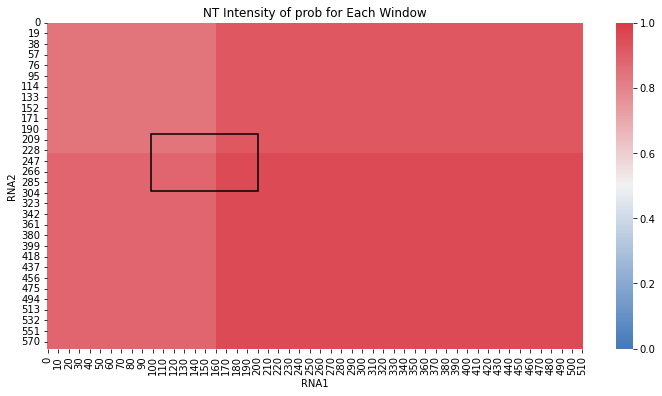

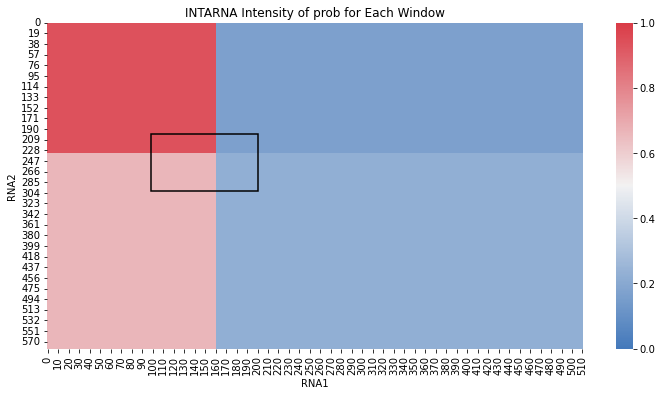

easypos ENSG00000137818_ENSG00000249915 1285


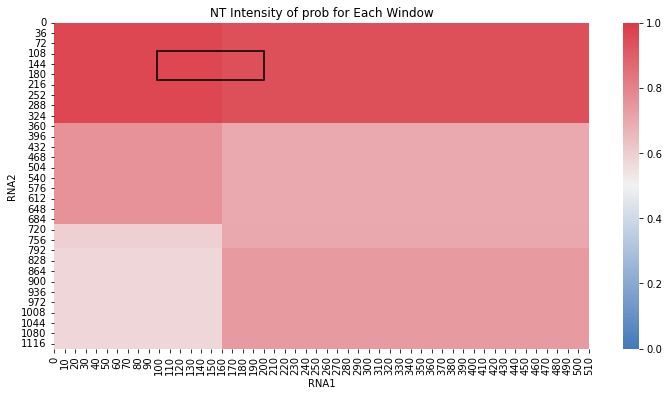

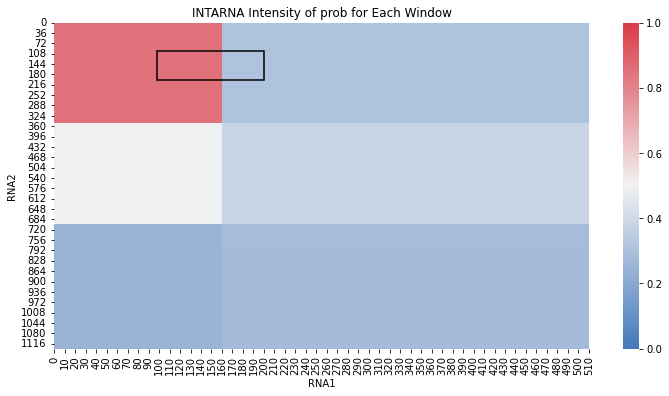

easypos ENSG00000087086_ENSG00000229117 391


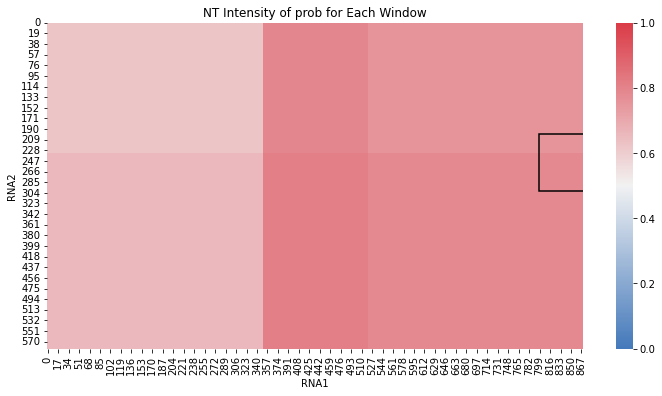

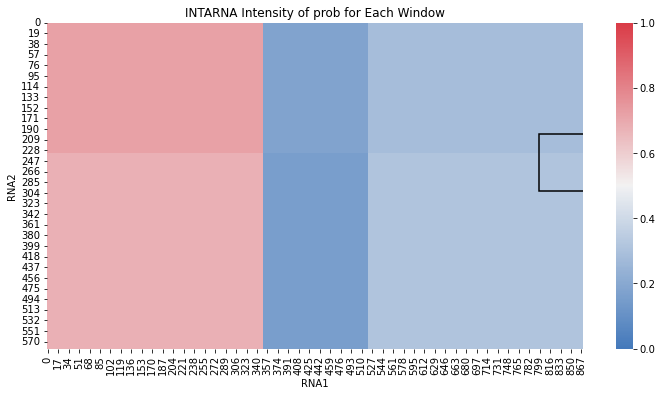

easypos ENSG00000087086_ENSG00000278229 393


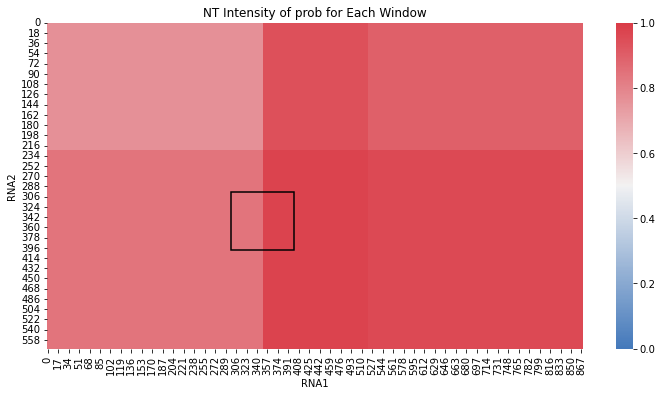

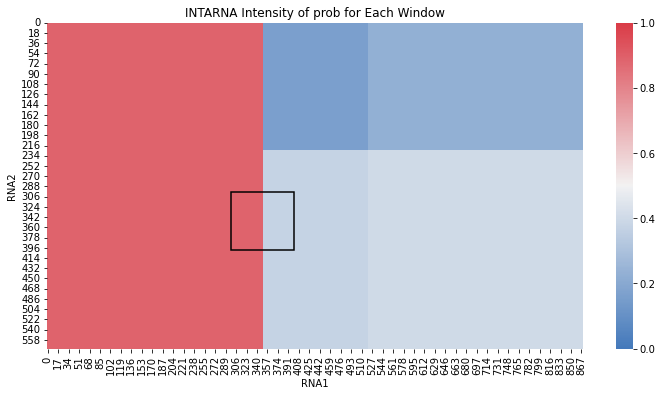

easypos ENSG00000142937_ENSG00000273686 1420


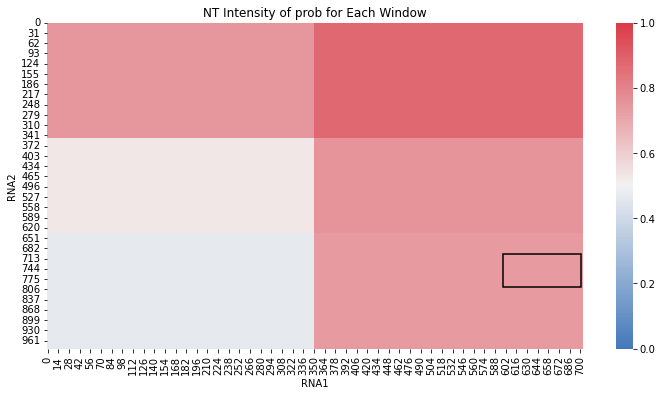

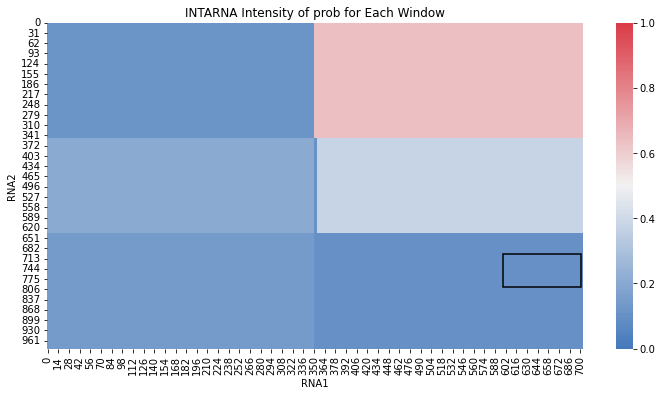

easypos ENSG00000089009_ENSG00000229117 409


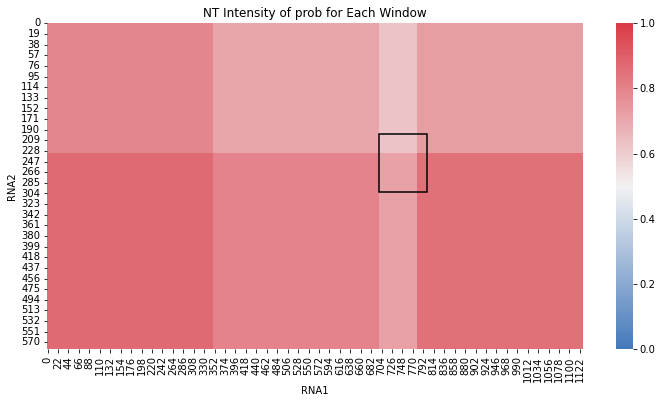

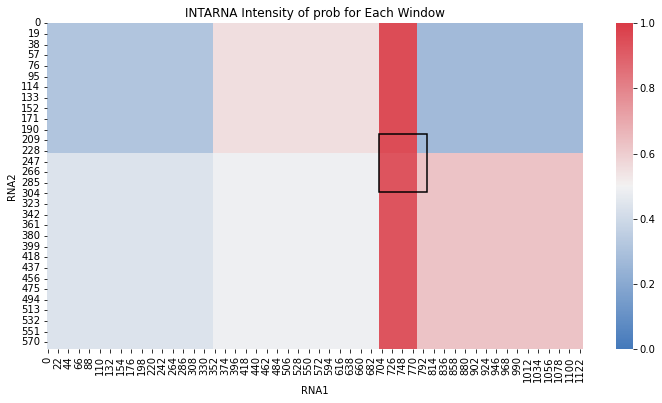

easypos ENSG00000198242_ENSG00000205542 1948


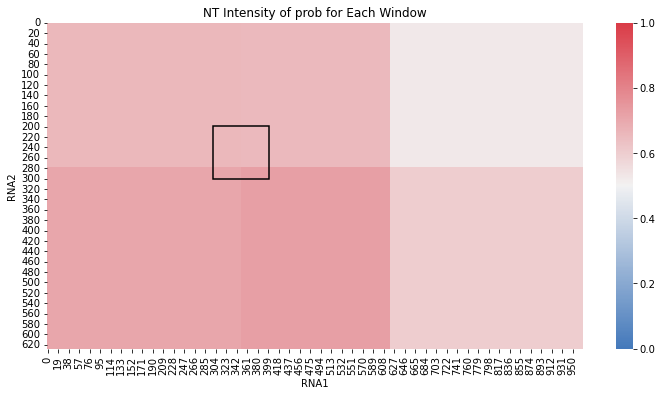

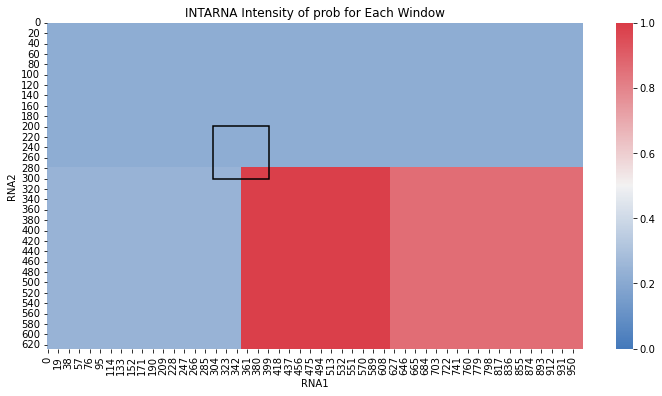

easypos ENSG00000167996_ENSG00000197958 1821


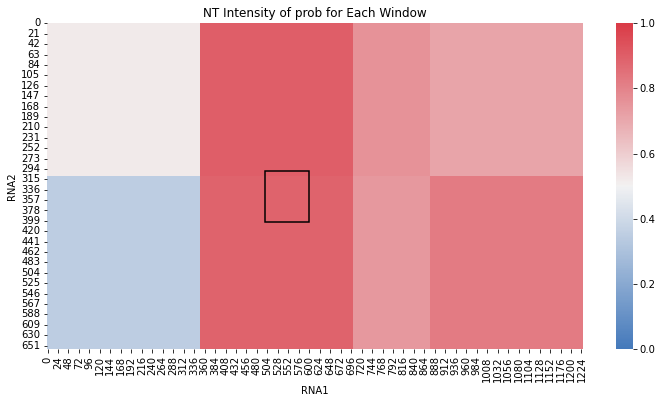

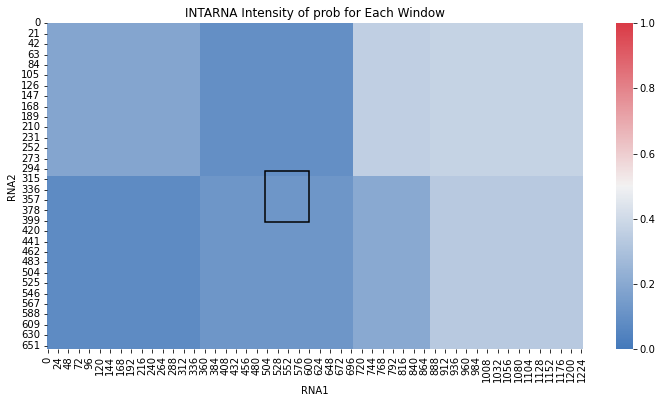

easypos ENSG00000108298_ENSG00000273686 671


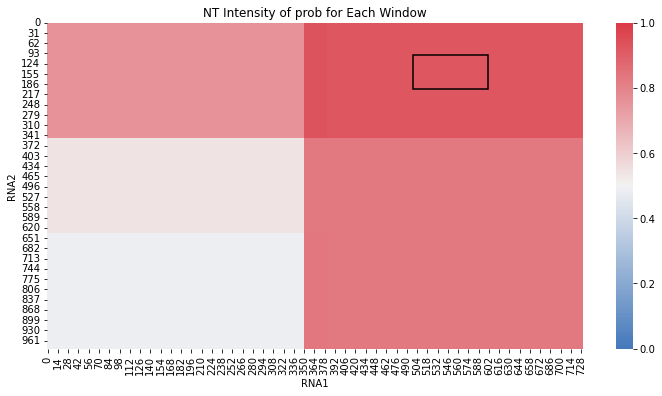

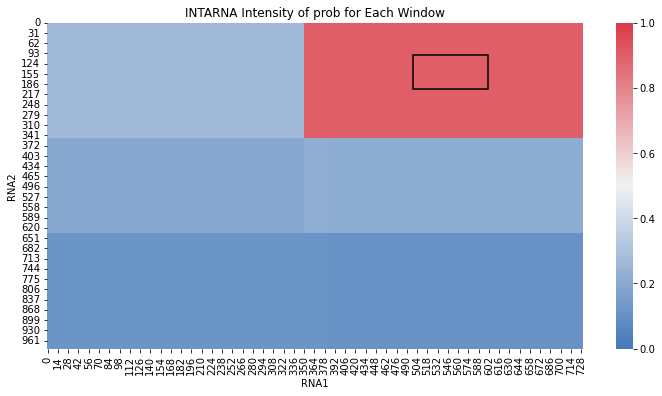

easypos ENSG00000089157_ENSG00000136942 417


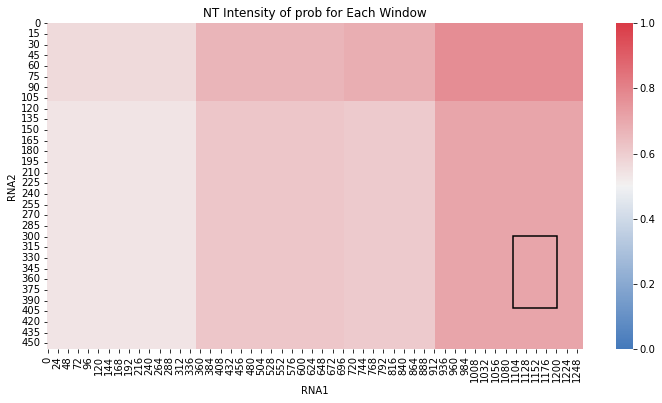

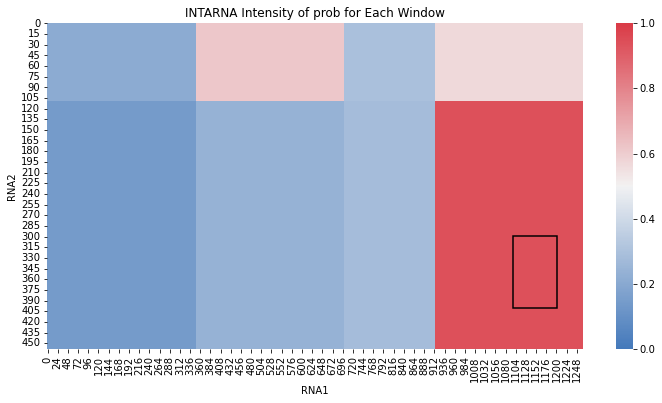

easypos ENSG00000136942_ENSG00000187514 1195


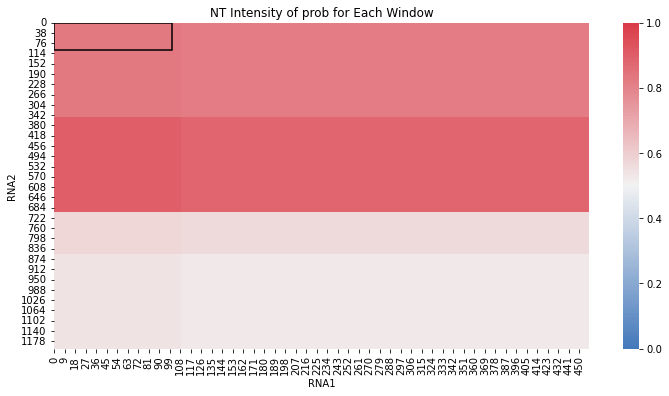

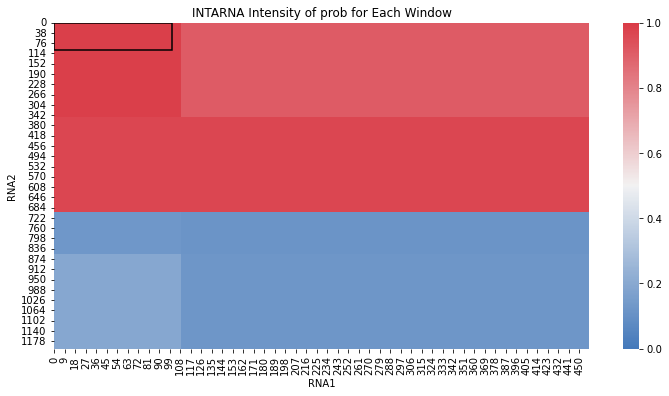

easypos ENSG00000143947_ENSG00000178172 1452


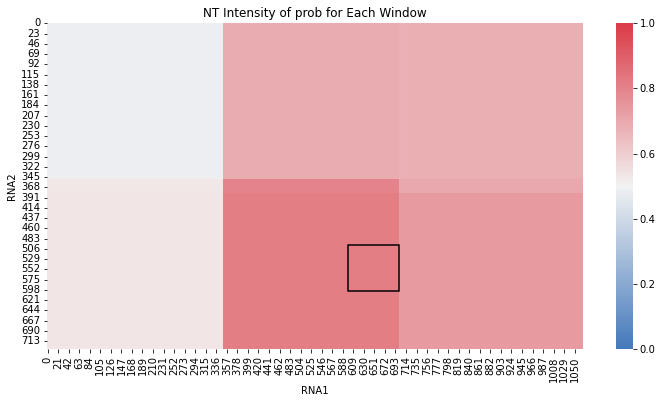

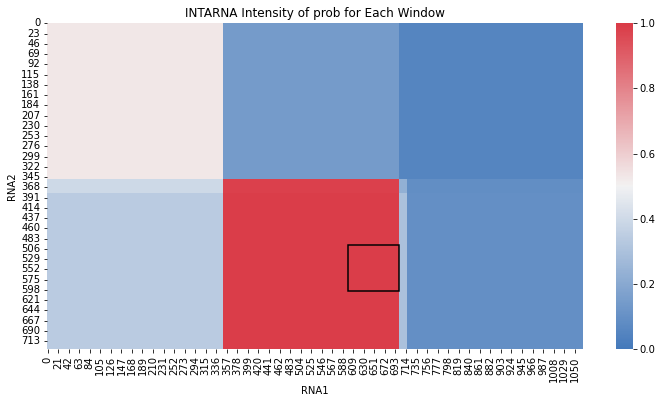

easypos ENSG00000205542_ENSG00000229117 1964


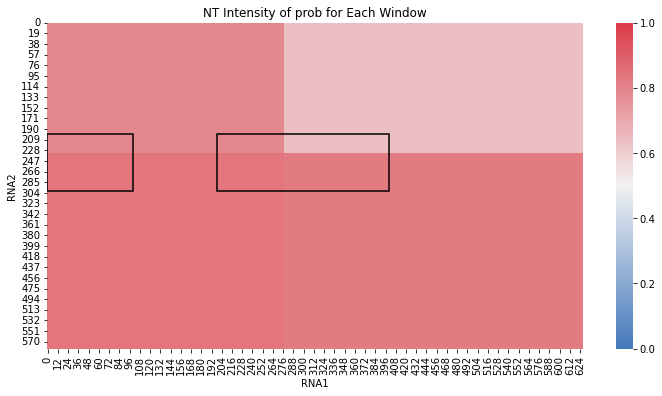

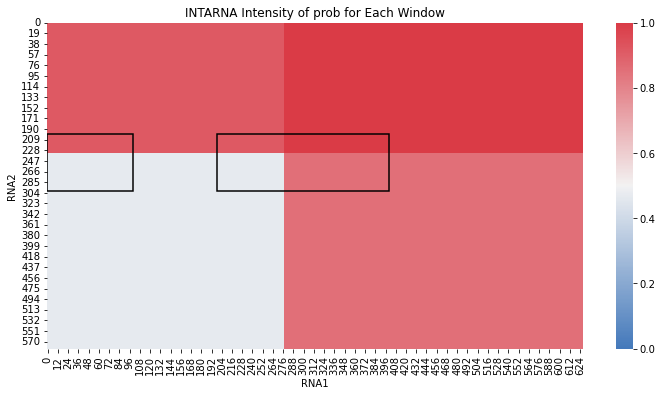

easypos ENSG00000089157_ENSG00000205542 430


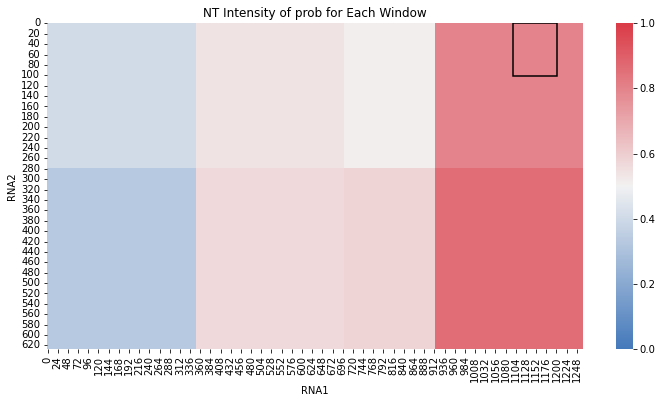

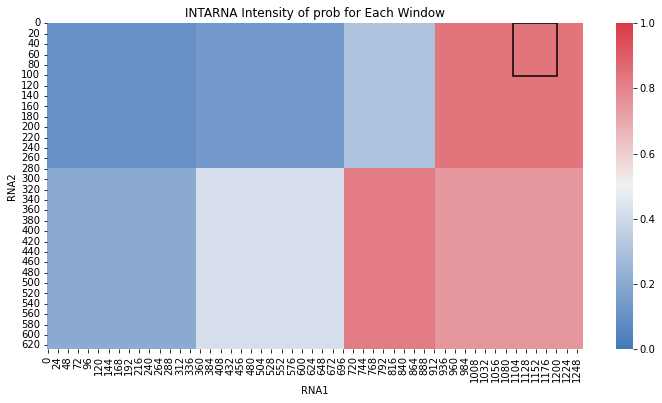

easypos ENSG00000136942_ENSG00000213145 1199


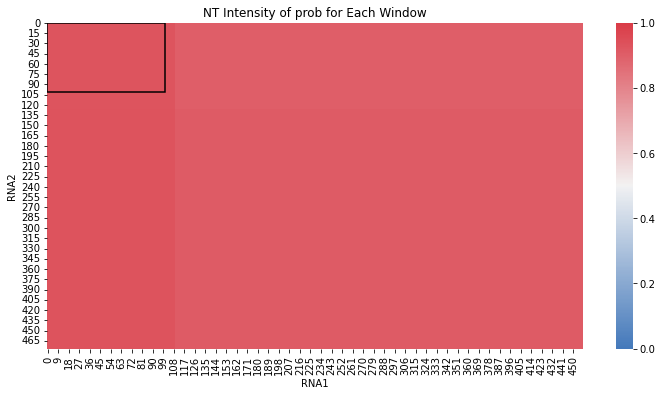

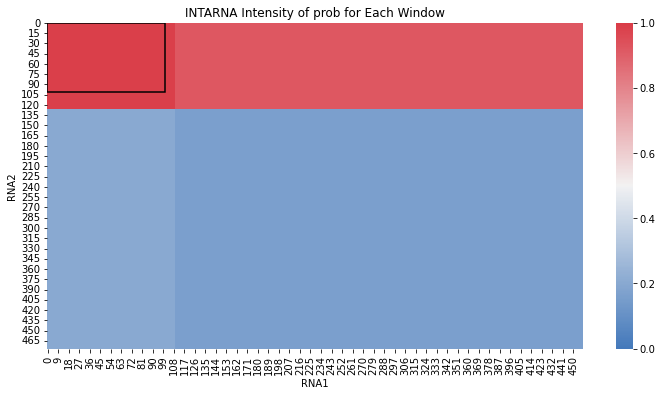

easypos ENSG00000104904_ENSG00000177600 556


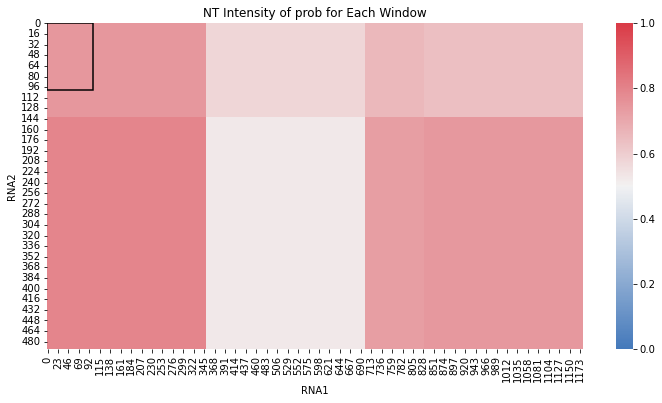

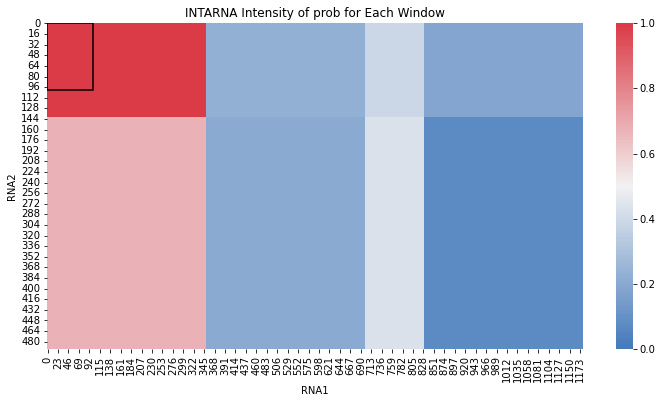

easypos ENSG00000229117_ENSG00000278229 1985


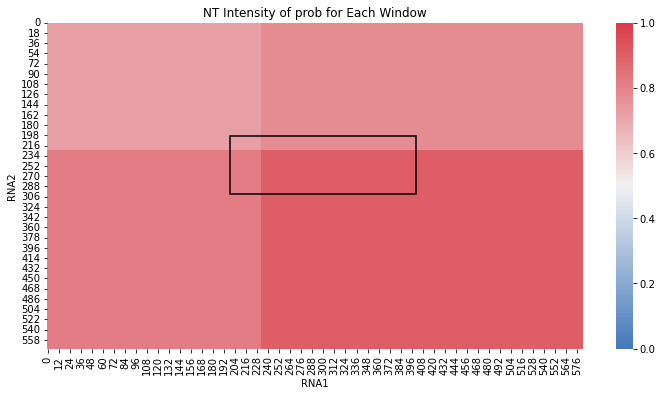

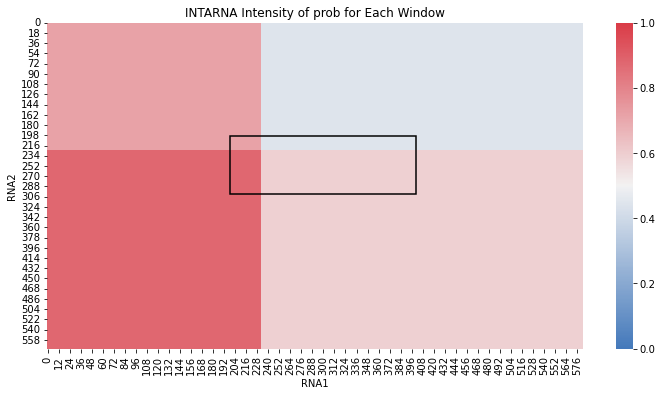

easypos ENSG00000137154_ENSG00000205323 1223


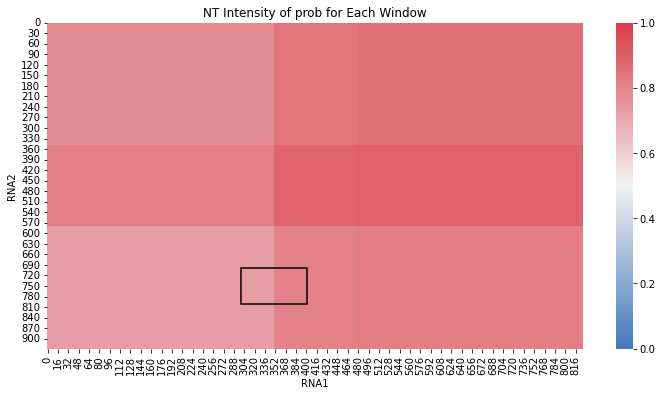

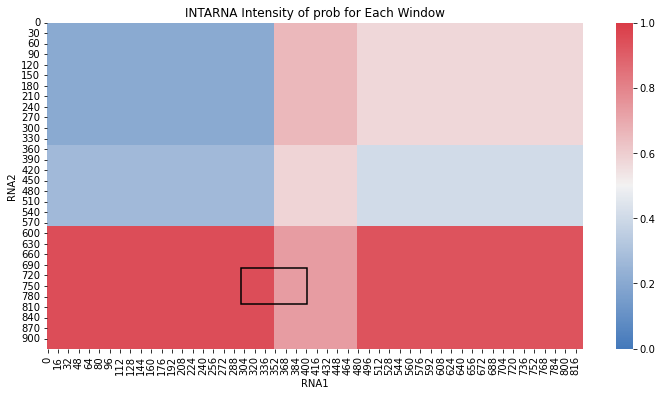

easypos ENSG00000172757_ENSG00000273607 1867


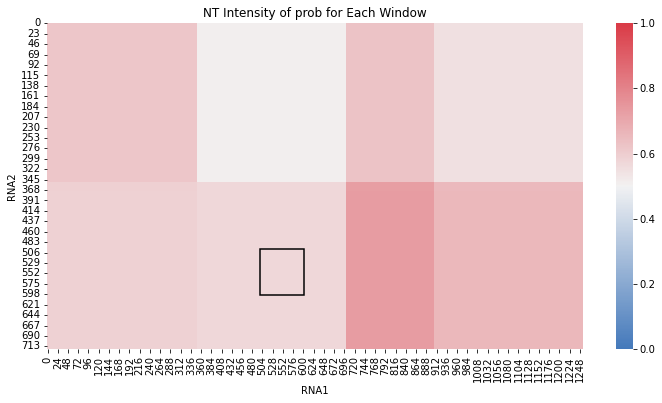

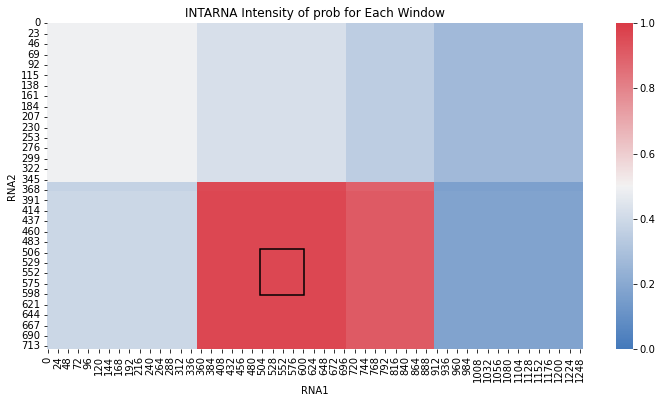

easypos ENSG00000110492_ENSG00000274950 718


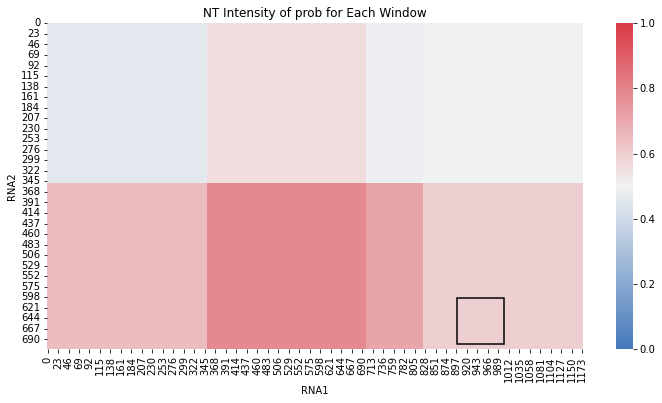

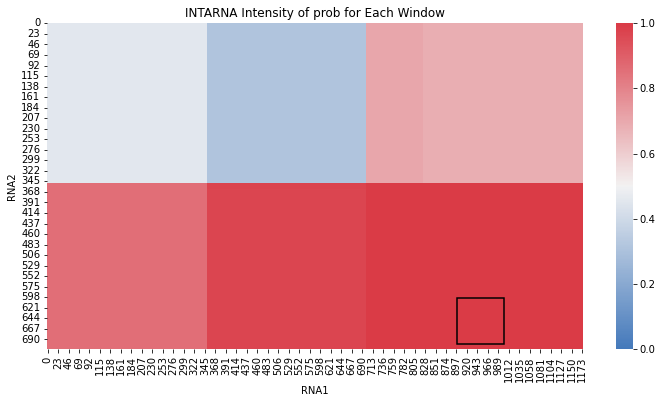

easypos ENSG00000105640_ENSG00000132507 590


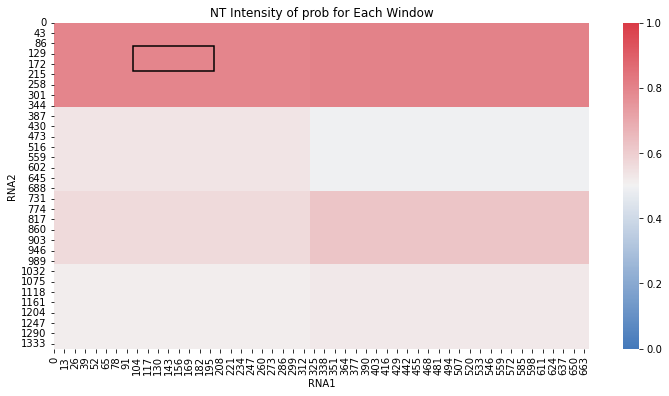

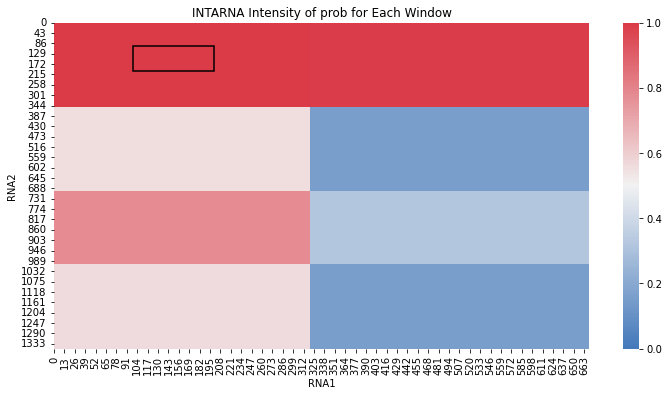

easypos ENSG00000087086_ENSG00000122406 355


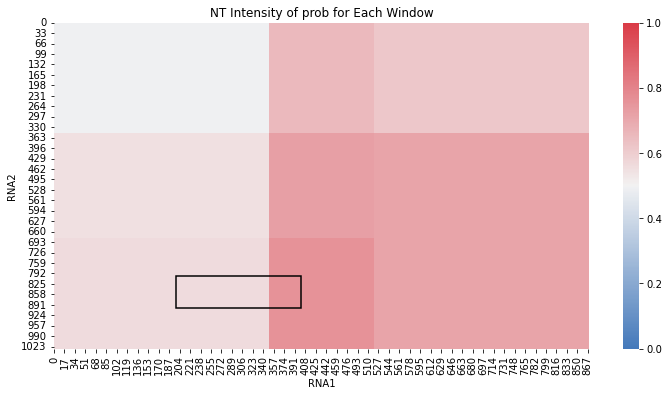

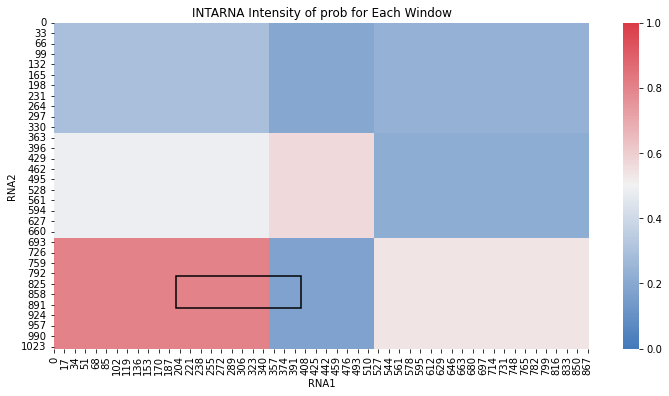

easypos ENSG00000177954_ENSG00000229117 1893


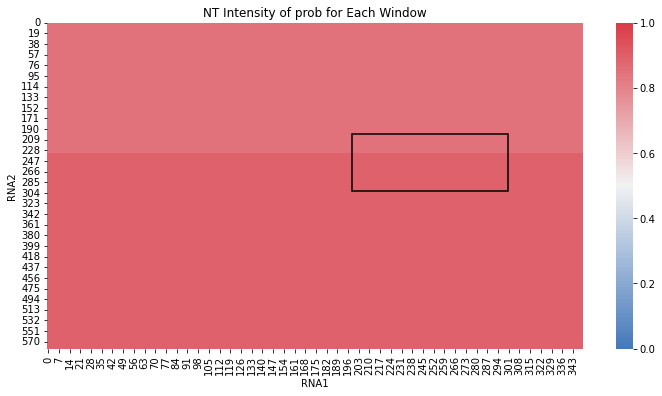

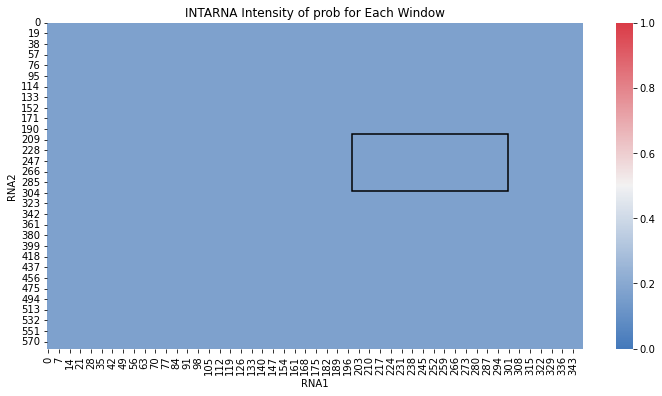

easypos ENSG00000137818_ENSG00000162244 1258


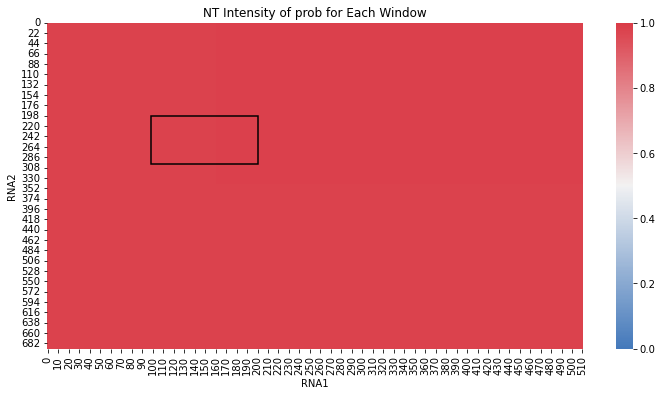

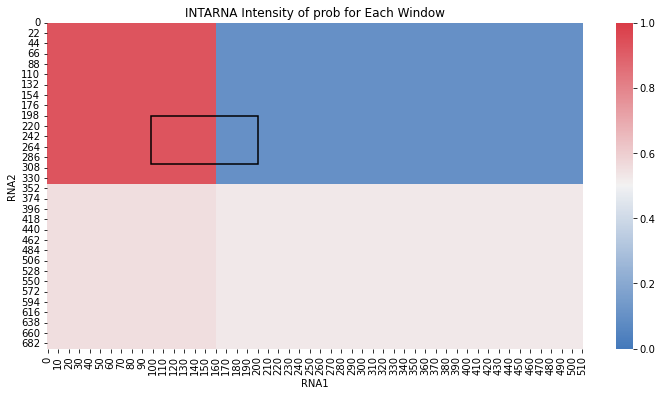

easypos ENSG00000115268_ENSG00000177600 875


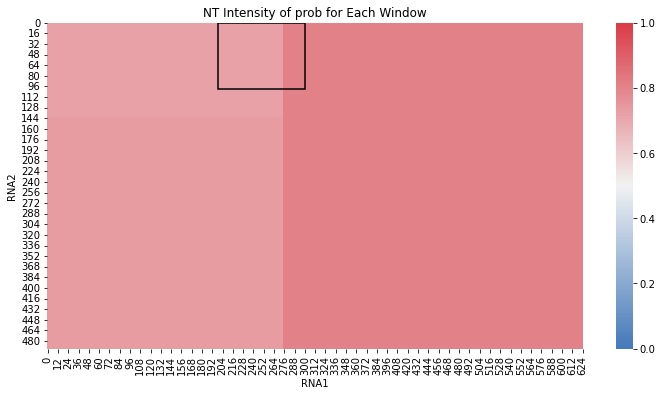

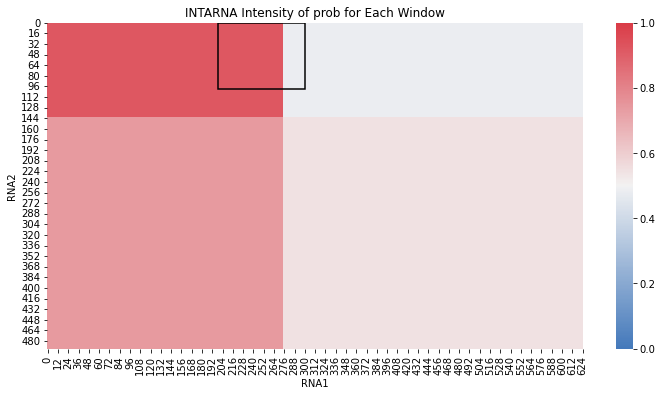

easypos ENSG00000181163_ENSG00000205542 1902


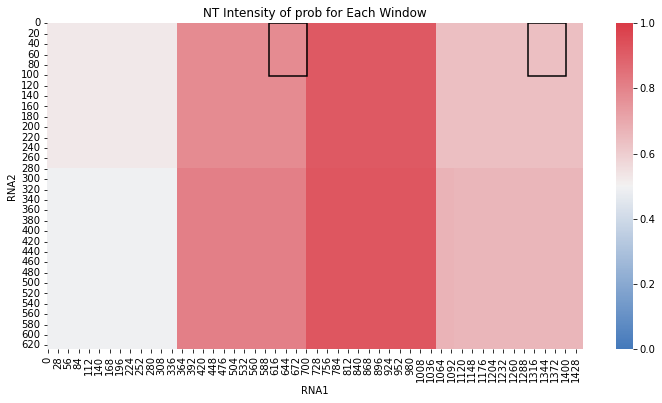

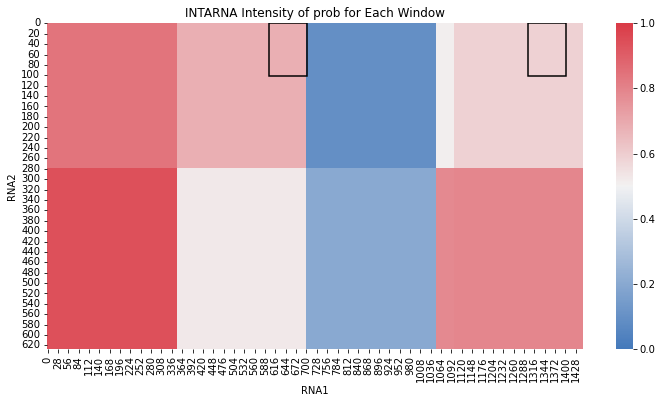

easypos ENSG00000134419_ENSG00000167996 1146


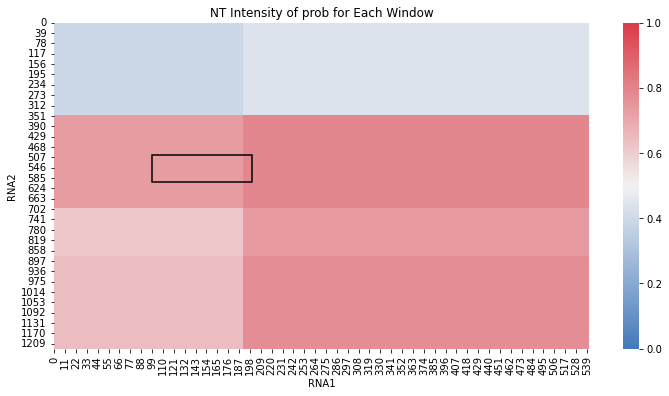

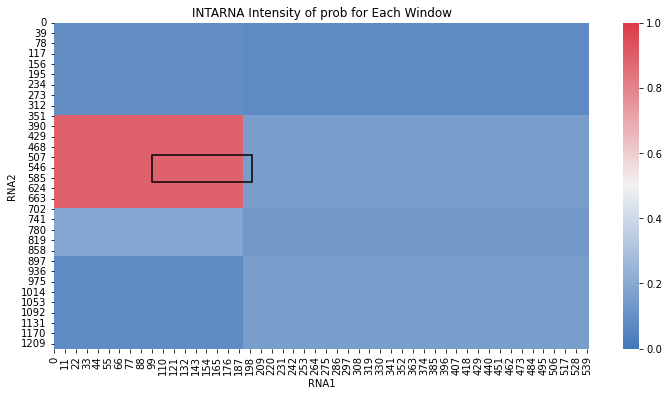

easypos ENSG00000142676_ENSG00000197958 1403


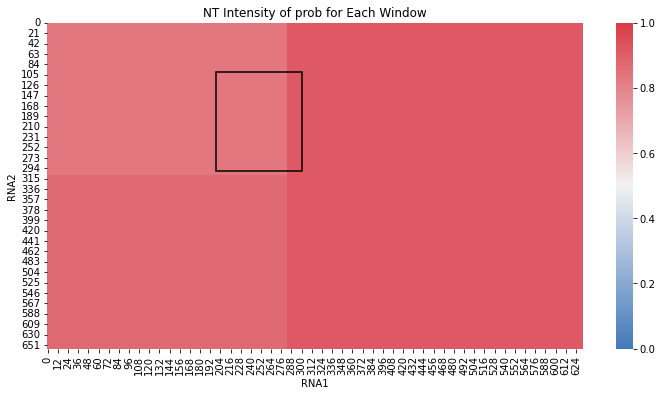

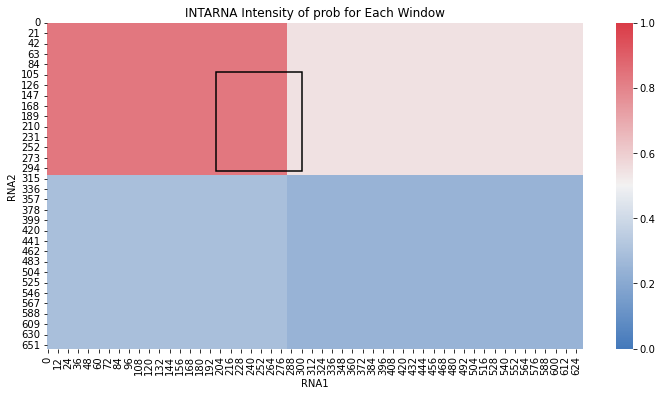

easypos ENSG00000142676_ENSG00000205542 1404


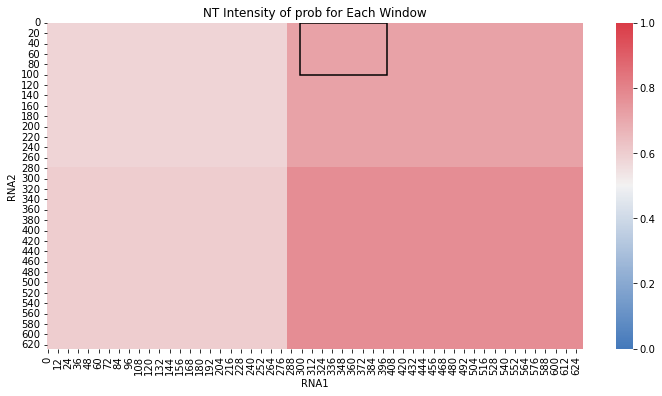

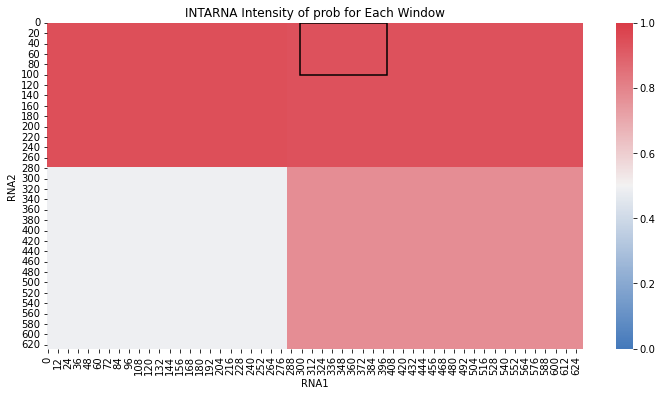

easypos ENSG00000137818_ENSG00000197756 1277


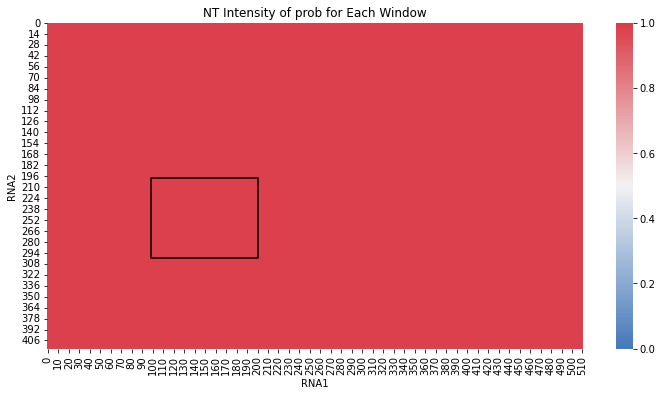

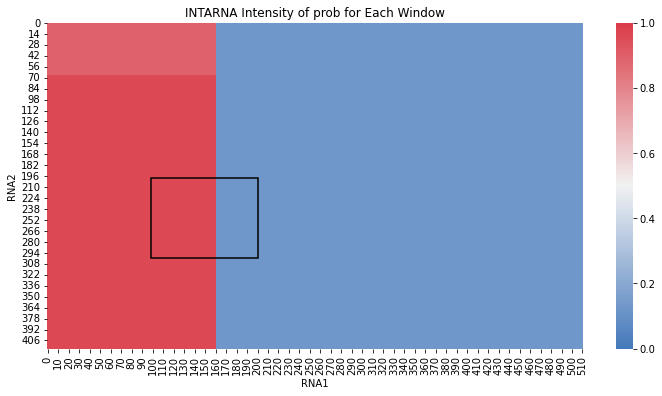

In [23]:
for id_s in tqdm(id_to_test, total = len(id_to_test)): # for couples in tqdm(couples_to_test, total = len(couples_to_test))

    subset_nt = res[res.id_sample == int(id_s)] #subset_nt = df_nt[df_nt.couples == couples]

    for _, row_nt in subset_nt.iterrows():
        
        print(row_nt.policy, row_nt.couples, row_nt.id_sample)
        
        couples = row_nt.couples
        
        id_sample = row_nt.id_sample
        
        dir_couple = os.path.join(output_dir, couples)
        dir_row = os.path.join(dir_couple, str(id_sample))
        result = pd.read_csv(os.path.join(dir_row, 'nt_result.csv'))
        with open(os.path.join(dir_row, 'interacting_regions.pkl'), 'rb') as file:
            interacting_regions = pickle.load(file)
        
        
        intarna_couple = intarna[intarna.couples == id_sample][['x1', 'x2', 'y1', 'y2', 'E_norm_conf']]
        result = result.merge(intarna_couple, how = 'left', left_on = ['x1', 'x2', 'y1', 'y2'], right_on = ['x1', 'x2', 'y1', 'y2'])
        
        
        # Define the range of x and y values
        x_range = range(0, int(result.max().x2))
        y_range = range(0, int(result.max().y2))

        # Create an empty 2D array to store the prob values in the grid
        heatmap_data = [[0 for _ in x_range] for _ in y_range]
        heatmap_intarna = [[0 for _ in x_range] for _ in y_range]

        # Fill the heatmap_data with 'prob' values
        for _, row in result.iterrows():
            x1, x2, y1, y2, prob, cdna1_slice, cdna2_slice, intarnascore = row
            x1, x2, y1, y2 = int(x1), int(x2), int(y1), int(y2)
            for x in range(x1, x2):
                for y in range(y1, y2):
                    heatmap_data[y][x] = prob
                    heatmap_intarna[y][x] = intarnascore
                    
        name = str(row_nt.id_sample) + row_nt.policy + row_nt.couples
        
        if os.path.exists(os.path.join(plot_dir, name + '_NT.png')) == False:
            make_plot(heatmap_data, interacting_regions, x_range, y_range, model = 'NT', savepath = os.path.join(plot_dir, name + '_NT.png'), show_plot = show_plot)
        if os.path.exists(os.path.join(plot_dir, name + '_INTARNA.png')) == False:
            make_plot(heatmap_intarna, interacting_regions, x_range, y_range, model = 'INTARNA', savepath = os.path.join(plot_dir, name + '_INTARNA.png'), show_plot = show_plot)

RNA DI RICSEQ 

pos abbastanza grandi:
- ENSG00000248109_ENSG00000251562 (2 pos, 1 HN) very good, High confidences
- ENSG00000231064_ENSG00000245532 (2 pos, 1 HN) ok
- ENSG00000220804_ENSG00000245532 (2 pos, 1 HN) not so good the pos, good the neg
- ENSG00000120656_ENSG00000251562 (2 pos, 1 HN) good
- ENSG00000060688_ENSG00000261150 (2 pos, 1 HN) good, quite high confidences
- ENSG00000117308_ENSG00000245532 (2 pos, 1 HN) not good the pos, good the neg
- ENSG00000163635_ENSG00000285258 (1 pos) good

SN abbastanza grandi:

- ENSG00000146374_ENSG00000245532 good (3 SN)
- ENSG00000142178_ENSG00000168214 ok 
- ENSG00000142178_ENSG00000172115 very good
- ENSG00000015479_ENSG00000196498 very good (3 SN)
- ENSG00000021826_ENSG00000155846 very good (3 SN, EN)
- ENSG00000021826_ENSG00000197603 ok SN, very good the EN (2 SN, 1 EN)
- ENSG00000154608_ENSG00000181143 very good SN and EN (2 SN, 1 EN)